In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
folder = '/Users/julianganzabal/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/'

In [4]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

In [7]:
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [8]:
non_toxic_ratio = (Y_train.sum(axis = 1) == 0).sum()/Y_train.shape[0]
print(non_toxic_ratio)

0.898254336307


In [9]:
Y_train_binary = 1*(Y_train.sum(axis = 1) > 0)
Y_valid_binary = 1*(Y_valid.sum(axis = 1) > 0)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.99, min_df=1,
                                   max_features=max_features,
                                   #tokenizer=tokenize,
                                   stop_words='english')

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

CPU times: user 9.68 s, sys: 440 ms, total: 10.1 s
Wall time: 10.6 s


In [30]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

CPU times: user 1.02 s, sys: 37.7 ms, total: 1.06 s
Wall time: 1.08 s


In [31]:
tfidf_matrix_train.shape, tfidf_matrix_valid.shape

((143613, 5000), (15958, 5000))

In [32]:
dense_matrix_train = tfidf_matrix_train.todense()
dense_matrix_valid = tfidf_matrix_valid.todense()

In [33]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from helper import PlotLosses
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras import initializers

In [34]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
# default_initializer = 'zeros'

In [39]:
input_features = dense_matrix_train.shape[1]
output_size = 1
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
# model_sig_nn.add(Dense(200,
#                        input_dim=input_features, 
#                        kernel_regularizer=regularizers.l2(lambd), 
#                        kernel_initializer=default_initializer,
#                        name="Capa_Oculta_1"))
# model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(BatchNormalization(input_shape=(input_features,)))
model_sig_nn.add(Dense(128,
                       #input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('relu'))
model_sig_nn.add(Dropout(0.25))
model_sig_nn.add(Dense(output_size,
                       #input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.001 
batch_size = 256
epochs = 10

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 5000)              20000     
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 128)               640128    
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 1)                 129       
_________________________________________________________________
output (Activation)          (None, 1)                 0         
Total para

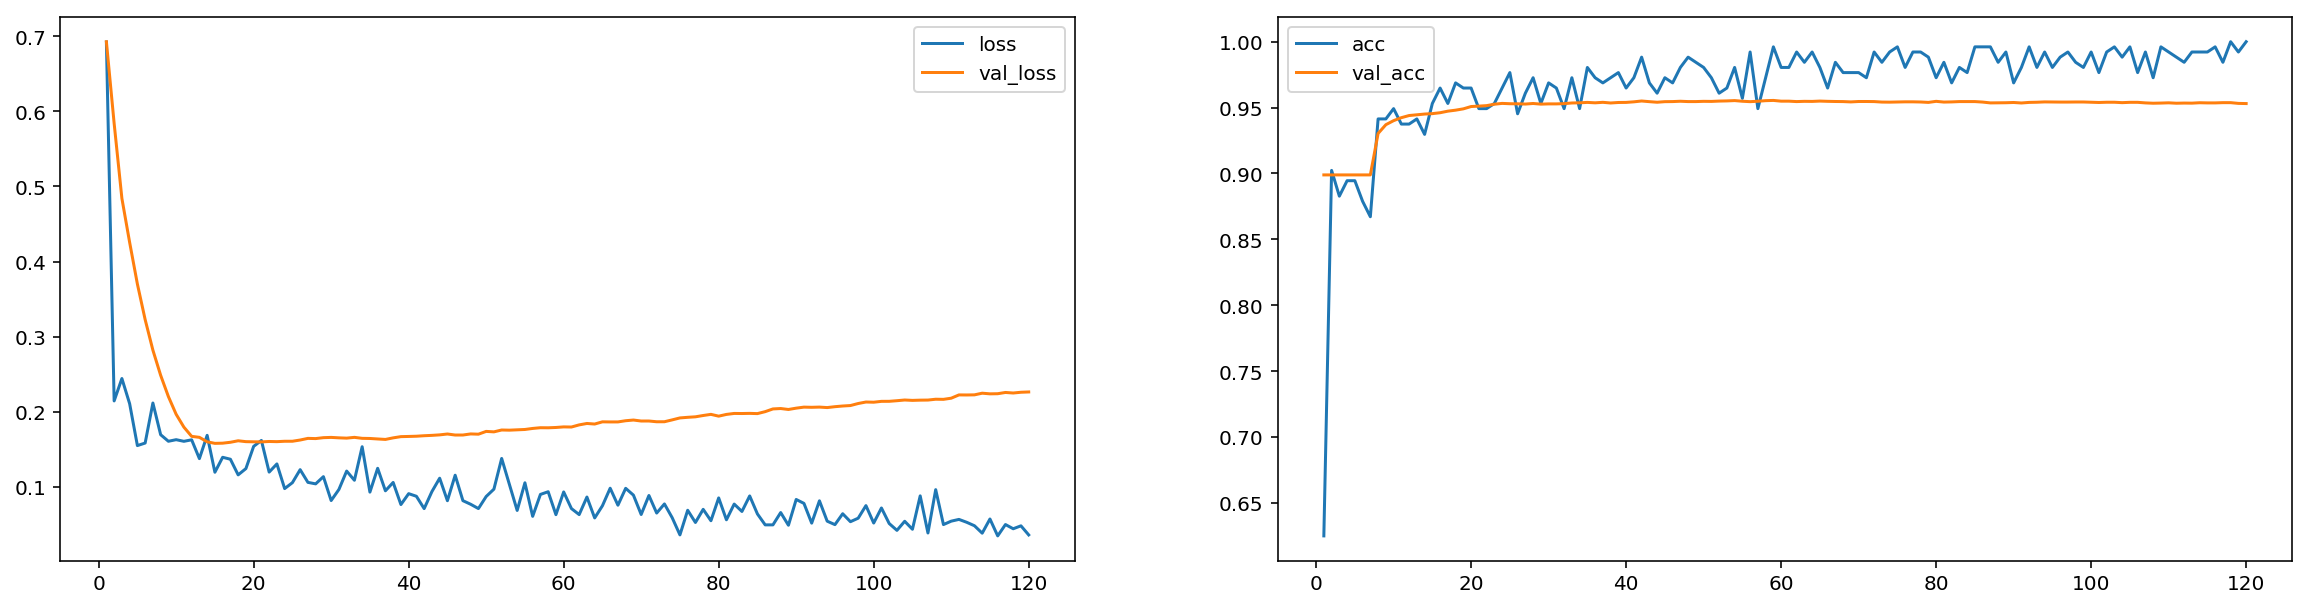

Epoch 00010: val_loss did not improve
143613/143613 [==============================] - 103s 720us/step - loss: 0.0515 - acc: 0.9903 - val_loss: 0.2263 - val_acc: 0.9531


In [40]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='toxic_binary.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=50, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid_binary)
history = model_sig_nn.fit(dense_matrix_train, 
          Y_train_binary, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid_binary), 
          callbacks=[plot_losses, checkpointer],
         )